In [1]:
%pylab inline

import galsim as gs
import mccd


import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


Populating the interactive namespace from numpy and matplotlib


In [2]:
e1_path = '/Users/oa265351/Desktop/denoising/datasets/realistic_dataset/data/e1_psf.npy'
e2_path = '/Users/oa265351/Desktop/denoising/datasets/realistic_dataset/data/e2_psf.npy'
size_path = '/Users/oa265351/Desktop/denoising/datasets/realistic_dataset/data/seeing_distribution.npy'




In [5]:
# Load data
e1_data = np.load(e1_path, allow_pickle=True)
e2_data = np.load(e2_path, allow_pickle=True)
size_data = np.load(size_path, allow_pickle=True)[()]



In [6]:
# Generate interpolators
e1_interp = mccd.dataset_generation.MomentInterpolator(moment_map=e1_data)
e2_interp = mccd.dataset_generation.MomentInterpolator(moment_map=e2_data)


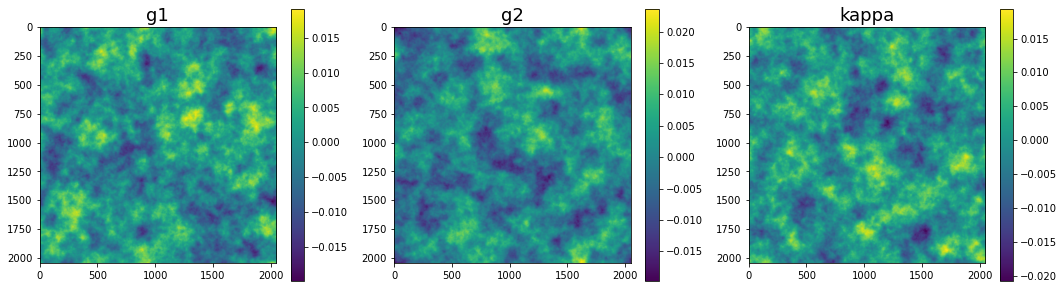

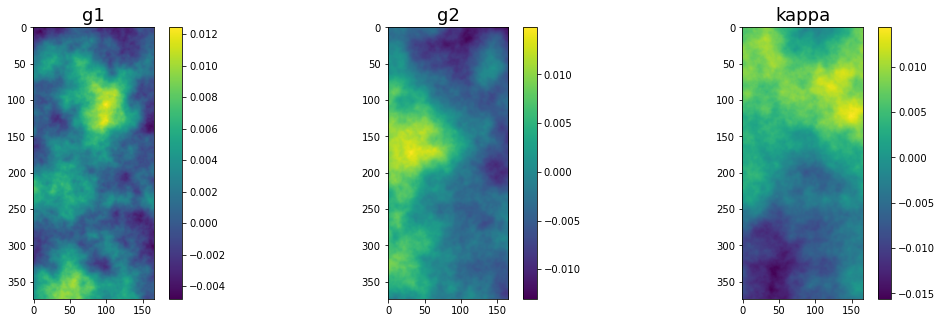

In [5]:
# Generate atmosphere
atmosphere = mccd.dataset_generation.AtmosphereGenerator(ngrid=2048)
atmosphere.plot_realisation()


In [6]:
# 
size_data.support()

(0.30683687729269266, 7.226888296251297)

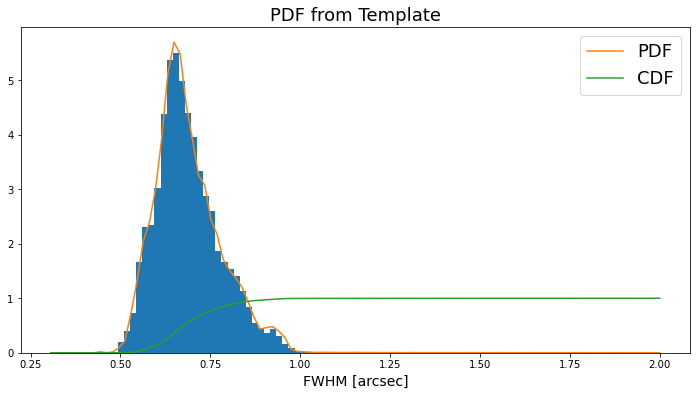

In [7]:
# Check the distribution and the sample generation
# I'm limiting the range to a max value of 2

# .ppf() function is the inverse of the .cdf() function (Cumulative distribution function)

x_min = size_data.support()[0]
x_max = size_data.support()[1]
X = np.linspace(x_min, 2, 100)


plt.figure(figsize=(12,6))
plt.hist(size_data.ppf(np.random.rand(10000)), range=(x_min, 2), density=True, bins=100)
plt.plot(X, size_data.pdf(X), label='PDF')
plt.plot(X, size_data.cdf(X), label='CDF')
plt.legend(fontsize=18)
plt.title("PDF from Template", fontsize=18)
plt.xlabel('FWHM [arcsec]', fontsize=14)
plt.show()



In [8]:
# Let's go from FWHM in arcsec to the values we need to simulate stars.

beta = 4.765
image_size = 51
pix_scale = 0.187
    

fwhm = size_data.ppf(np.random.rand(1))  # already in arcsec
print('fwhm: ', fwhm)
moffat_prof = gs.Moffat(beta=beta, fwhm=fwhm)

psf_image = gs.ImageF(image_size, image_size)
moffat_prof.drawImage(image=psf_image, scale=pix_scale)


fwhm:  [0.72972924]


galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), array=
array([[3.2658207e-10, 3.6676337e-10, 4.4026555e-10, ..., 4.4026555e-10,
        3.6676337e-10, 3.2658207e-10],
       [3.6676337e-10, 4.5343568e-10, 5.3522414e-10, ..., 5.3522414e-10,
        4.5343568e-10, 3.6676337e-10],
       [4.4026555e-10, 5.3522414e-10, 6.7244732e-10, ..., 6.7244732e-10,
        5.3522414e-10, 4.4026555e-10],
       ...,
       [4.4026555e-10, 5.3522414e-10, 6.7244732e-10, ..., 6.7244732e-10,
        5.3522414e-10, 4.4026555e-10],
       [3.6676337e-10, 4.5343568e-10, 5.3522414e-10, ..., 5.3522414e-10,
        4.5343568e-10, 3.6676337e-10],
       [3.2658207e-10, 3.6676337e-10, 4.4026555e-10, ..., 4.4026555e-10,
        3.6676337e-10, 3.2658207e-10]], dtype=float32), wcs=galsim.PixelScale(0.187))

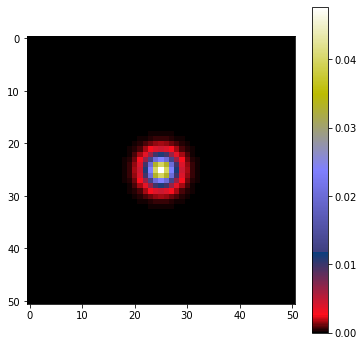

In [9]:

plt.figure(figsize=(6,6))
imshow(psf_image.array, cmap='gist_stern');colorbar()
show()


In [10]:


size_data.ppf(np.random.rand(1))


array([0.80384897])

In [31]:


class ExposureSimulation(object):
    """ Simulate one exposure.
    
    Generate a random exposure and the give the ellipticities and size
    of the PSF for any position in the focal plane.
    
    Parameters
    ----------
    e1_bin_path: str
        e1 data path.
    e2_bin_path: str
        e2 data path.
    fwhm_dist_path: str
        fwhm distribution path.
    fwhm_range: [float, float]
        The range for the possible fwhm. Units in arcsec.
        Default for CFIS data.
    atmos_kwargs: dict
        Atmosphere arguments.
    e1_kwargs: dict
        e1 interpolator arguments.
    e2_kwargs: dict
        e2 interpolator arguments.
    
    """
    def __init__(self, e1_bin_path=None, e2_bin_path=None, fwhm_dist_path=None,
                 fwhm_range=[0.45,1.], atmos_kwargs={}, e1_kwargs={}, e2_kwargs={}):
        
        # Variables
        self.atmos_kwargs = atmos_kwargs
        self.e1_kwargs = e1_kwargs
        self.e2_kwargs = e2_kwargs
        self.e1_bin_path = e1_bin_path
        self.e2_bin_path = e2_bin_path
        self.fwhm_dist_path = fwhm_dist_path
        self.fwhm_range = fwhm_range
        
        # Variables to init
        self.atmosphere = None
        self.e1_bins = None
        self.e1_interp = None
        self.e2_bins = None
        self.e2_interp = None
        self.mean_fwhm = None
        
        self.current_e1 = None
        self.current_e2 = None
        self.current_fwhm = None
        self.current_pos = None
        
        # Initialize exposure
        self.init_exposure()
    
    
    def init_exposure(self):
        """ Initialise exposure variables. """
        # Generate atmosphere
        self.atmosphere = mccd.dataset_generation.AtmosphereGenerator(**self.atmos_kwargs)
        
        # Generate e1 interpolator
        self.e1_bins = np.load(self.e1_bin_path, allow_pickle=True)
        self.e1_interp = mccd.dataset_generation.MomentInterpolator(
            moment_map=self.e1_bins, **self.e1_kwargs)
        
        # Generate e2 interpolator
        self.e2_bins = np.load(self.e2_bin_path, allow_pickle=True)
        self.e2_interp = mccd.dataset_generation.MomentInterpolator(
            moment_map=self.e2_bins, **self.e2_kwargs)

        # Sample the mean size from the size distribution
        self.fwhm_dist = np.load(self.fwhm_dist_path, allow_pickle=True)[()]
        # Draw a sample from the distribution
        self.mean_fwhm = self.fwhm_dist.ppf(np.random.rand(1))
        # Check that it is between the limits and draw again if it is not the case
        while self.mean_fwhm < self.fwhm_range[0] or self.mean_fwhm > self.fwhm_range[1]:
            self.mean_fwhm = self.fwhm_dist.ppf(np.random.rand(1))
    
    def regenerate_exposure(self):
        """ Regenerate a random exposure. """
        # Regenerate atmosphere
        self.atmosphere.regenerate_atmosphere()
        # Regenerate mean size
        # Draw a sample from the distribution
        self.mean_fwhm = self.fwhm_dist.ppf(np.random.rand(1))
        # Check that it is between the limits and draw again if it is not the case
        while self.mean_fwhm < self.fwhm_range[0] or self.mean_fwhm > self.fwhm_range[1]:
            self.mean_fwhm = self.fwhm_dist.ppf(np.random.rand(1))
        
        
    def interpolate_values(self, target_x, target_y):
        """ Interpolate exposure values.
        
        For some target positions interpolate the values (e1, e2, fwhm).
        The input positions are in global MCCD coordinates.
        """
        # Save current positions
        self.current_pos = [target_x, target_y]
        # First calculate the mean variations
        if np.isscalar(target_x):
            self.current_e1 = self.e1_interp.interpolate_position(target_x, target_y)
            self.current_e2 = self.e2_interp.interpolate_position(target_x, target_y)
        else:
            self.current_e1 = np.array([
                self.e1_interp.interpolate_position(_x, _y)
                for _x, _y in zip(target_x, target_y)])
            self.current_e2 = np.array([
                self.e2_interp.interpolate_position(_x, _y)
                for _x, _y in zip(target_x, target_y)])
        
        self.current_fwhm = np.ones_like(self.current_e1) * self.mean_fwhm
        
        # Calculate and add the atmospheric part
        atm_contribution = self.atmosphere.interpolate_position(target_x, target_y)
        self.current_e1 += atm_contribution[0]
        self.current_e2 += atm_contribution[1]
        self.current_fwhm = self.current_fwhm * atm_contribution[2]
        
        return self.current_e1, self.current_e2, self.current_fwhm

    


In [41]:


# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

def plot_ccds_fun(positions,mom,title):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    for ccd_it in range(40):
        xs,ys = loc2glob.shift_coord(ccd_it)
        rect = mpl.patches.Rectangle((xs,ys),2048,4612,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect)

    im1 = ax1.scatter(positions[:, 0], positions[:, 1], s=5,c=mom, marker='*', cmap=newcmp)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_xticks([]);ax1.set_yticks([])
    ax1.axis('off')
    ax1.set_title(title)
    plt.show()


In [33]:
# Simulate an exposure

loc2glob = mccd.mccd_utils.Loc2Glob()

exposure_sim = ExposureSimulation(e1_bin_path=e1_path,
                                  e2_bin_path=e2_path,
                                  fwhm_dist_path=size_path,
                                  atmos_kwargs={'ngrid': 2048})




In [34]:
# Simulate some random values

# Get the maximum values for the global positions (in pixels])
max_x = loc2glob.x_npix * 6 + loc2glob.x_gap * 5
min_x = loc2glob.x_npix * (-5) + loc2glob.x_gap * (-5)
max_y = loc2glob.y_npix * 2 + loc2glob.y_gap * 1
min_y = loc2glob.y_npix * (-2) + loc2glob.y_gap * (-2)


pos_x = min_x + np.random.rand(4000) * (max_x - min_x)
pos_y = min_y + np.random.rand(4000) * (max_y - min_y)


In [35]:

interp_e1, interp_e2, interp_fwhm = exposure_sim.interpolate_values(pos_x, pos_y)


In [36]:
interp_e1.shape

(4000,)

In [38]:

pos = np.array([pos_x, pos_y]).T
pos.shape

(4000, 2)

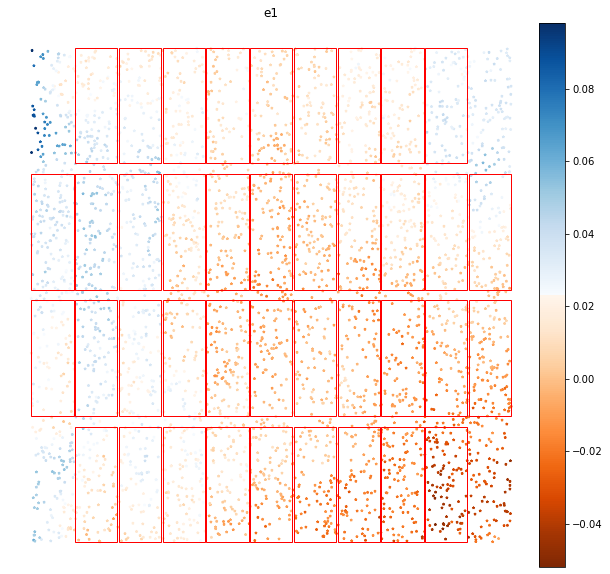

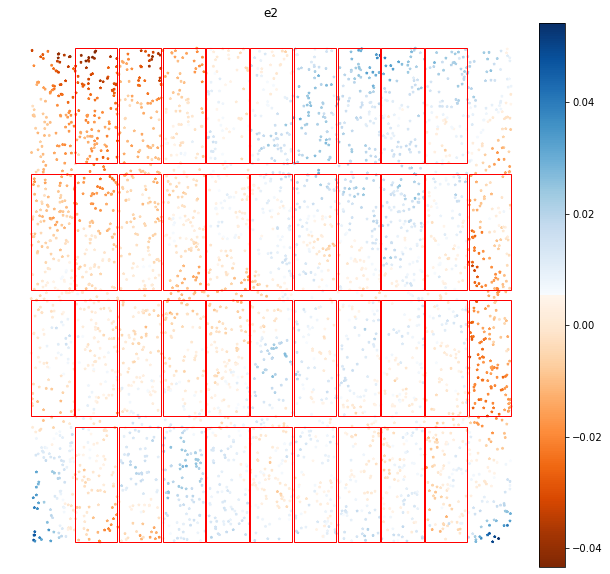

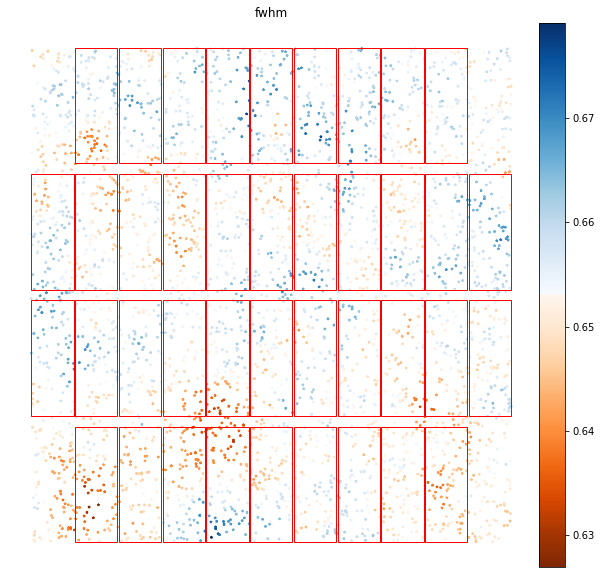

In [42]:


plot_ccds_fun(pos, interp_e1, title='e1')
plot_ccds_fun(pos, interp_e2, title='e2')
plot_ccds_fun(pos, interp_fwhm, title='fwhm')
